In [77]:
# Look for possible beacons using Zeek data
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [78]:
ssh = SSHCommand(address='172.16.1.17', username='venator', password='cpt701cpt701')
result = ssh.execute('echo -e \"timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts\" && zcat /nsm/zeek/logs/2022-08-17//conn.* | jq -j \'select(.conn_state == \"SF\") | .[\"ts\"], \",\", .[\"duration\"], \",\", .[\"orig_bytes\"], \",\", .[\"resp_bytes\"], \",\", .[\"orig_pkts\"], \",\", .[\"resp_pkts\"], \"\n\"\' | awk -F \":\" \'{print $1,$3}\'')

In [79]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
all_pkts = df['orig_pkts'] + df['resp_pkts']
all_bytes = df['orig_bytes'] + df['resp_bytes']
df["all_pkts"] = all_pkts
df["all_bytes"] = all_bytes
df['date'] = pd.to_datetime(df['timestamp'],unit='s')
df

,timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,all_pkts,all_bytes,date
0,1.660694e+09,2.039075,50.0,114.0,1,1,2,164.0,2022-08-17 00:00:02.372251904
1,1.660694e+09,4.064150,93.0,243.0,2,2,4,336.0,2022-08-17 00:00:02.300108032
2,1.660694e+09,2.038839,50.0,105.0,1,1,2,155.0,2022-08-17 00:00:02.372555008
3,1.660694e+09,4.068380,93.0,243.0,2,2,4,336.0,2022-08-17 00:00:06.365487104
4,1.660694e+09,2.034879,50.0,114.0,1,1,2,164.0,2022-08-17 00:00:44.372294912
...,...,...,...,...,...,...,...,...,...
16052,1.660781e+09,74.195386,23700.0,27619.0,214,130,344,51319.0,2022-08-17 23:57:50.560344832
16053,1.660781e+09,5.396579,2290.0,2573.0,24,17,41,4863.0,2022-08-17 23:58:59.359493888
16054,1.660781e+09,91.754582,35393.0,107219.0,157,116,273,142612.0,2022-08-17 23:57:32.973409792
16055,1.660781e+09,61.649581,683528.0,1656085.0,3244,3073,6317,2339613.0,2022-08-17 23:58:03.106742016


In [80]:
# Don't run this cell until fixed. Tryining to get date/time to 1 hour increments

from io import StringIO
import pandas as pd
import datetime

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

#print(result)
#df = string_to_df(result)

ts2 = df['timestamp'].iloc[0] # Get the first timestamp of the log
#orig_ip = df['id.orig_h'].iloc[0]

test = "ts,all_pkts_hour,all_bytes_hour\n"
ts_index = 0
pkts_index = 0
all_pkts_hour = 0
all_bytes_hour = 0
df_pkts = pd.DataFrame(columns=["ts","all_pkts_hour","all_bytes_hour"])
for index,value in df['timestamp'].sort_values().items():
    ts1 = value
    ts_count = value
    if ts_count >= ts2 + 3600: # if the value of the current timestamp is 3600 seconds (1 hour) equal to or greater than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] # get total packet count for this index
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index]
#        all_bytes = all_bytes + df['all_bytes'].iloc[index] # get total byte count for this index
#        all_pkts_hour = all_pkts # set total packets for the hour
#        print(all_pkts)
        epoch_time = ts1
        datetime_time = datetime.datetime.fromtimestamp(epoch_time) # create ISO date from epoch_time
#        print(datetime_time,"\t",all_pkts)
        test += str(datetime_time) + ',' + str(all_pkts_hour) + ',' + str(all_bytes_hour) + '\n' #build list for pandas array
        all_pkts_hour = 0
        all_bytes_hour = 0
        ts2 = value
    else: # else if the current timestamp is less than 3600 seconds than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] #increment origpkts
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index] # increment respPkts
#        all_pkts = all_pkts + respPkts + origPkts # add origPkts and respPkts to all_pkts
#        print(all_pkts)
#        origPkts = 0
#        respPkts = 0

df_pkts = pd.read_csv(StringIO(str(test)), sep=",")
#print(test)
#print(df_pkts)

<AxesSubplot:xlabel='ts'>

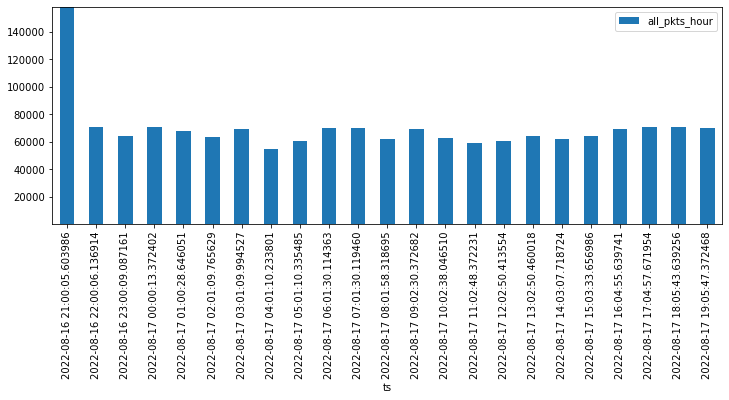

In [81]:
MAX_Y =  (df_pkts.loc[:, 'all_pkts_hour']).max()
df_pkts.plot(x="ts", y="all_pkts_hour", kind="bar", figsize=(12,4), ylim=(0.1,MAX_Y))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_hour'>

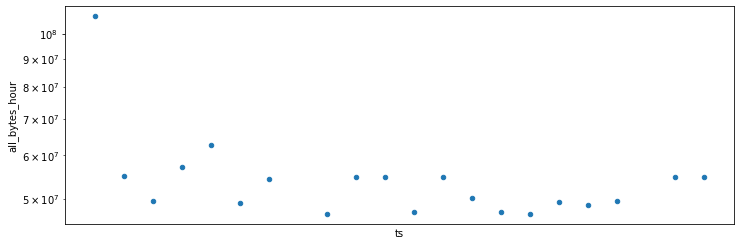

In [82]:
df_pkts.plot(x="ts", y="all_bytes_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_hour'>

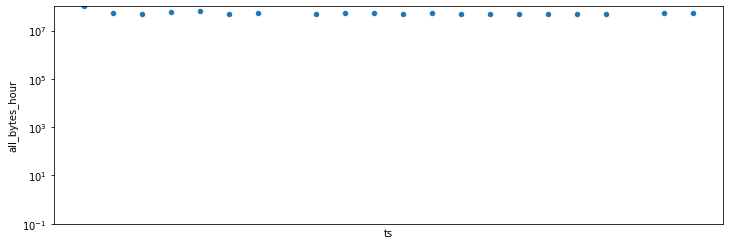

In [83]:
df_pkts.plot(x="ts", y="all_bytes_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_hour'>

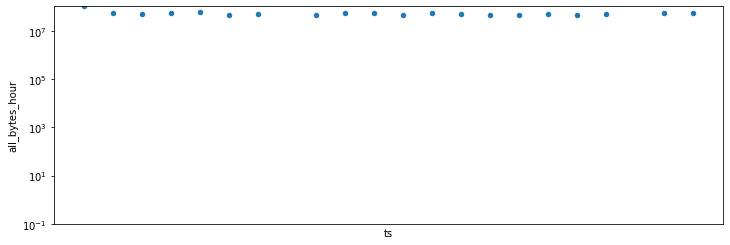

In [84]:
MAX_Y =  (df_pkts.loc[:, 'all_bytes_hour']).max()
df_pkts.plot(x="ts", y="all_bytes_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,MAX_Y))

In [85]:
import numpy as np
packets = df_pkts.loc[:, 'all_pkts_hour']
print(packets)
np.isnan(packets)

0     158320
1      70568
2      63841
3      70938
4      67718
5      63736
6      69166
7      54616
8      60790
9      70303
10     70242
11     61796
12     69472
13     63070
14     58978
15     60760
16     63863
17     62251
18     63865
19     69127
20     70451
21     70535
22     70317
Name: all_pkts_hour, dtype: int64


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
Name: all_pkts_hour, dtype: bool

In [86]:
fft = np.fft.rfft(packets)
np.isnan(packets)
fft

array([1604723.            +0.j        ,  122873.08598496 -2737.6992989j ,
        115807.61086005+15922.64050816j,   65923.54523003 -5907.02172871j,
         87683.69400476+18738.18655603j,   98939.02669747 -4356.88092675j,
         82844.65824486-15990.24191012j,  102826.28800129+25674.48285604j,
         98268.1915565 -21831.68849431j,   79737.04057993-10136.31974635j,
         74850.28101321 -7378.04420725j,   88565.07782694+13958.97726979j])

C:\Users\Venator\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


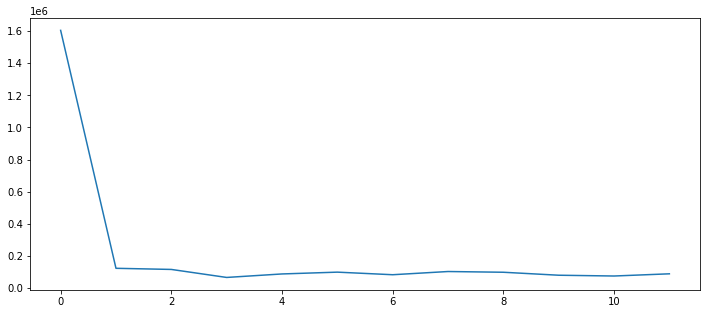

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()

In [88]:
import numpy as np
bytesPre = df_pkts.loc[:, 'all_bytes_hour']
bytes = bytesPre.dropna()
print(bytes)
np.isnan(bytes)

0     107560065.0
1      54968533.0
2      49456265.0
3      57086362.0
4      62731534.0
5      49157881.0
6      54316333.0
8      46931593.0
9      54670779.0
10     54670816.0
11     47239484.0
12     54687885.0
13     50100987.0
14     47221970.0
15     46899773.0
16     49402302.0
17     48605919.0
18     49449365.0
20     54794424.0
21     54870084.0
Name: all_bytes_hour, dtype: float64


0     False
1     False
2     False
3     False
4     False
5     False
6     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
20    False
21    False
Name: all_bytes_hour, dtype: bool

In [89]:
fft = np.fft.rfft(bytes)
np.isnan(bytes)
fft

array([1.09482235e+09       +0.j        ,
       7.07611697e+07-25760458.35218944j,
       6.41893695e+07 -2127742.7007191j ,
       4.07992107e+07+10812443.97534265j,
       5.53143258e+07+16754167.33412645j,
       7.09630050e+07 +7509661.j        ,
       4.74446595e+07 -7654708.57421165j,
       6.37873111e+07-15973422.44377688j,
       3.06738272e+07-13086818.25244711j,
       5.52922085e+07+14311923.88375524j,
       5.79287720e+07       +0.j        ])

C:\Users\Venator\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


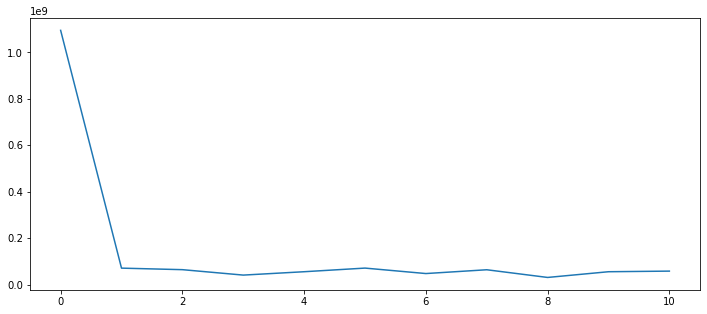

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()